In [11]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def chi2(y,yfit):
    res = 0
    for i in range(len(yfit)):
        res = res + (y[i]-yfit[i])**2/(0.9724)**2 #The denominator should be the unbias Sipm voltage in mV
    return (res / len(yfit))

def waveform(x, C, start, m, end, A, d):
    condlist = [x < start, (x >= start) & (x < end), x >= end]
    funclist = [lambda x: C, lambda x: m*x+(C - m*start), lambda x: (A * np.exp(d * x) + (m*end + (C - m*start) - A * np.exp(d*end)))]
    return np.piecewise(x, condlist, funclist)

In [46]:
inputfile = "fermilabP2P_short.txt"
outputfile = 'fermilaboutput.txt'
filenumber = 1
channelnum = 3 #DRS4 board channel, ranges 1 to 4 -- should be expanded to do multiple channels at once.  

p0=(0,150,-1,160,-10,-0.01) #p0:C,start,m,end,A,d -- adjust start and end to match approx time of pulse falling edge
chi2cut = 2
highVcut = 10 #cut just above noise level, in (mV) 

In [70]:
p2ps = np.array([])
chisqs = np.array([])
with open(outputfile, 'w') as w:
    w.write("")
    for i in range(0, filenumber):                             #iterate through files
        w.write(f"File {i}, Channel {channelnum}")
        w.write('\n');
        with open(inputfile) as f:                            #modify to iterate through chosen filenames
            current_file = (f.read().split('-- Event'))
        
        for j in range(1, len(current_file)):                  #iterate through events 
            time = np.array([])
            voltage = np.array([])
            lines = current_file[j].split('\n')
            #print(f"Event Number {j}")

            for line in lines[6:1028]:                         #iterate through data points
                values = line.split()
                if float(values[channelnum+2]) > 10: continue               #cut the false peaks from the DRS4
                time = np.append(time, float(values[2]))
                voltage = np.append(voltage, float(values[channelnum+2]))

            popt, pcov = curve_fit(waveform, time, voltage,p0=p0, maxfev = 10000)

            #print(f"C:{popt[0]}, \n start:{popt[1]}, \n m: {popt[2]},\n end: {popt[3]},\n A: {popt[4]},\n d: {popt[5]}")
            """#show the waveform fit line
            s = []
            ys = []
            for i in range(500):
                xs.append(i)
                if i < popt[1]: ys.append(popt[0])
                elif i < popt[3]: ys.append(i*popt[2]+popt[0]-popt[2]*popt[1])
                else: ys.append(popt[4] * np.exp(popt[5] * i) + (popt[2]*popt[3] + (popt[0] - popt[2]*popt[1]) - popt[4] * np.exp(popt[5]*popt[3])))
                
            plot = plt.plot(time,voltage)
            plt.plot(xs,ys)
            plt.show()"""
            
            for i in range(len(time)): 
                if time[i] < popt[1]: startindex = i
            chisq = chi2(voltage[0:startindex],waveform(time[0:startindex], *popt))
            chisqs = np.append(chisqs,chisq)
            #print(f"chisq: {chisq}")
            
            if chisq < chi2cut:
                #w.write(f"Event Number {j}:\n")
                p2ps = np.append(p2ps,-popt[2]*(popt[3] - popt[1]))
                w.write(f"{-popt[2]*(popt[3] - popt[1]):.1f}\n")
print(f'Done!\nTotal events analyzed: {len(chisqs)}\nLow Chi Squared events: {np.count_nonzero(chisqs < chi2cut)}')

Done!
Total events analyzed: 12
Low Chi Squared events: 12


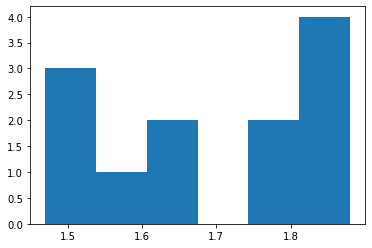

In [71]:
plt.hist(chisqs,6)
plt.show()

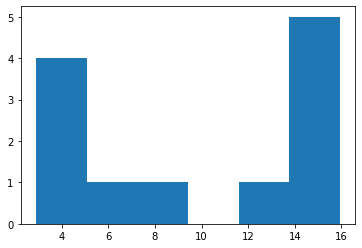

In [76]:
count,V_pp,bars = plt.hist(p2ps,6)
plt.show()